In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Data cleaning and Imputation
The following describes how the data points that had missing values for the PAY_1 variable were merged with the data points that had non-missing values. The same train/test split was applied to the non-missing data points as in previous chapters.

In [2]:
df_orig = pd.read_excel('default_of_credit_card_clients.xls')

In [3]:
feature_zero_mask = (df_orig.iloc[:, 1:] == 0).all(axis=1)

In [4]:
df_clean = df_orig[df_orig.iloc[:, 1:].any(axis=1)].copy()

Repeat previous data cleaning steps: adjust undocumented feature values

In [5]:
df_clean.loc[df_clean['EDUCATION'].isin([0, 5, 6]), 'EDUCATION'] = 4

In [6]:
df_clean.loc[df_clean['MARRIAGE'] == 0, 'MARRIAGE'] = 3

Now instead of throwing away samples with missing data, we fill them with `np.nan` which XGBoost can work with. Start by making a separate dataframe with just these values.

In [7]:
missing_pay_1_mask = df_clean['PAY_1'].isin(['Not available'])

In [8]:
df_missing_pay_1 = df_clean[df_clean['PAY_1'] == 'Not available'].copy()

Load cleaned data that had missing values removed:

In [9]:
df = pd.read_csv('final_cleaned_data.csv')

In [10]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6']
filtered_response = []
for item in features_response:
    if item not in items_to_remove:
        filtered_response.append(item)
features_response = filtered_response
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Replicate the train/test split from earlier

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(items_to_remove+["default payment next month"], axis=1).values, df["default payment next month"].values, test_size=0.2, random_state=24)

First, the 'Not available' string in the dataframe with missing values will be replaced with np.nan. Then a train/test split will be performed on this dataframe. The resulting non-missing and missing data points will be combined with the data points from the previous chapters to create the training and testing datasets.

Once the train/test split has been performed on the dataframe with only missing values, the resulting non-missing and missing data points will be merged with the previously split non-missing data points. This will create a combined dataset with both non-missing and missing data points for both the training and testing datasets.

In [12]:
df_fill_pay_1_filled = df_missing_pay_1.copy()
df_fill_pay_1_filled['PAY_1'] = np.nan

X_fill_pay_1 = df_fill_pay_1_filled[features_response[:-1]]
y_fill_pay_1 = df_fill_pay_1_filled['default payment next month']

X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(X_fill_pay_1,y_fill_pay_1,test_size=0.2, random_state=24)

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

# Using XGBoost


### Boosting
Boosting is a method used to create ensembles of machine learning models, typically decision trees. Unlike bagging, each new estimator added in boosting depends on all the estimators added before it. The boosting procedure proceeds in sequential stages and the predictions of ensemble members are added up to calculate the overall ensemble prediction. Boosting is also known as stagewise additive modeling. In other words in boosting the models are trained sequentially.  

Bagging trains many estimators using different random samples of the training data, while boosting trains new estimators using information about which samples were incorrectly classified by the previous estimators in the ensemble. Boosting focuses on these samples to improve the performance of the overall ensemble on the entire training dataset.


### Gradient Boosting and XGBoost
XGBoost uses the gradient descent idea to train decision trees in a stagewise additive manner. It utilizes information about the gradient and second derivatives of a loss function to train new decision trees and add them to the ensemble. XGBoost aims to decrease the error by moving the ensemble prediction in the direction of decreasing error, with the learning_rate hyperparameter controlling the size of the step taken. The approach of training decision trees using error gradients is an alternative to the node impurity concept used in decision trees and random forests.

In [13]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=24)

Note that we are using lossguide policy. In addition to the max_depth hyperparameter, XGBoost offers another way to control tree growth using the grow_policy hyperparameter. The default depthwise option grows trees up to a specified maximum depth, while the newer lossguide option splits nodes based on the greatest reduction in the loss function, regardless of depth. This may result in a tree with one or two very deep branches and other shallow branches. The lossguide option mimics the behavior of LightGBM.

In [14]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=30,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

generating leves from 5 to 200

In [15]:
max_leaves_values = np.arange(5, 206, 5)

In [16]:
eval_set = [(X_train_2, y_train_2), (X_val_2, y_val_2)]

We can create a visualization to observe how the validation AUC changes with increasing maximum number of leaves. This is similar to the visualization we previously created to observe the relationship between the learning rate and validation AUC.

In [17]:
%%time
aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model.set_params(max_leaves = max_leaves)
    xgb_model.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    
    #Get validation score
    val_set_pred_proba = xgb_model.predict_proba(X_val_2)[:,1]
    aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

CPU times: total: 5min 2s
Wall time: 1min 12s


Once the hyperparameter search is complete, we can create a dataframe containing the hyperparameters and their corresponding validation AUC values. We can then use this dataframe to plot the validation AUC against the maximum number of leaves. This will allow us to observe the relationship between the maximum number of leaves and the validation AUC, and help us identify the optimal value for this hyperparameter.

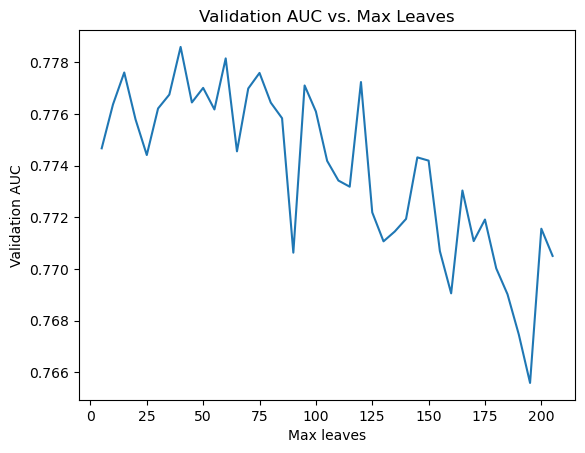

In [18]:
plt.plot(max_leaves_values, aucs)
plt.xlabel('Max leaves')
plt.ylabel('Validation AUC')
plt.title('Validation AUC vs. Max Leaves')
plt.show()

Despite some noise, the general trend we observe is that lower values of max_leaves tend to result in higher validation set ROC AUC scores. This is because allowing fewer leaves in the trees helps to limit their complexity and reduces the risk of overfitting. As a result, the model is better able to generalize to new data, which in turn improves the validation set score.

In [19]:
max_leaves_df_2 = pd.DataFrame(list(zip(max_leaves_values, aucs)), columns=['Max leaves', 'Validation AUC'])

In [20]:
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
print(max_auc_2)

0.7785918508068121


In [21]:
max_ix_2 = max_leaves_df_2['Validation AUC'] == max_auc_2
max_leaves_df_2[max_ix_2]

,Max leaves,Validation AUC
7,40,0.778592


The optimal value of max leaves is 40. So now we retrain the model with the hyperparameter as 40

In [22]:
xgb_model.set_params(max_leaves = 40)
xgb_model.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
              max_leaves=40, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [23]:
X_val_2_df = pd.DataFrame(X_val_2, columns=features_response[:-1])

To analyze the feature importance of our new model, we can create a SHAP explainer using the validation data as the background dataset, obtain the SHAP values, and make a summary plot. Here's the code to accomplish these tasks:

SHAP values enable individualized explanations of model predictions, allowing for the contribution of each feature to be understood for a single sample. This is different from the feature importance method used by random forests, which only considers the average feature importance across the training set. SHAP values are calculated relative to a background dataset, typically the training data. They are additive, meaning that they can be summed to recover the prediction value, such as a predicted probability.  
SHAP values represent the contribution of each feature value to the prediction of a sample, relative to the expected value. A small impact on the prediction results in a SHAP value close to zero, while a large effect pushes the predicted probability closer to 0 or 1, resulting in a further SHAP value from 0. Negative SHAP values indicate that a feature moves the prediction closer to 0, while positive SHAP values indicate a movement closer to 1.

In [24]:
explainer_2 = shap.explainers.Tree(xgb_model, data=X_val_2_df)

In [25]:
shap_values_2 = explainer_2(X_val_2_df)

 97%|=================== | 4631/4750 [00:21<00:00]       

In [26]:
shap_values_2.values.shape

(4750, 17)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


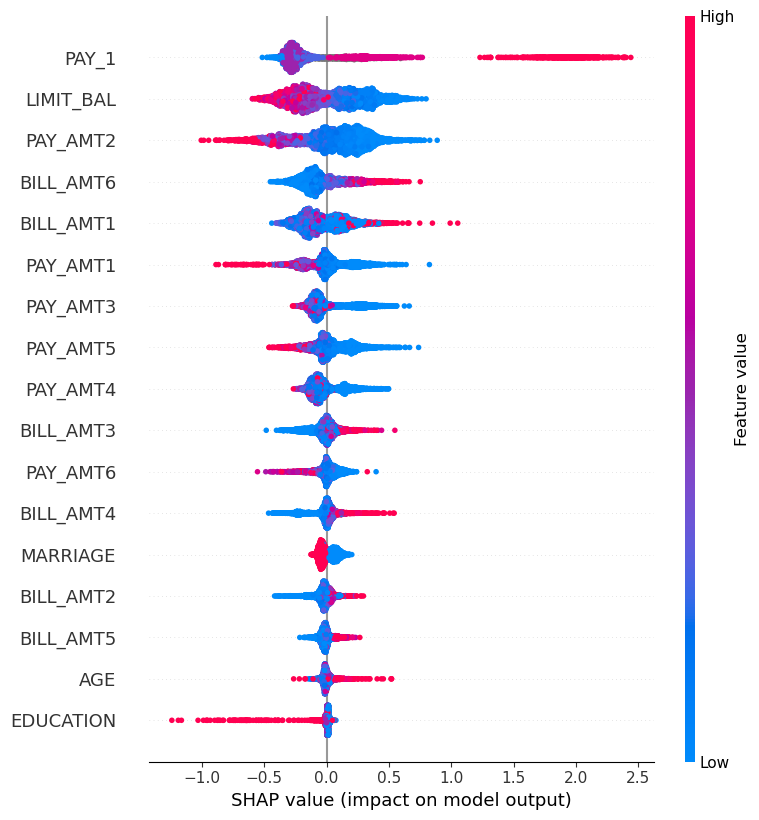

In [27]:
shap.summary_plot(shap_values_2.values, X_val_2_df)

In the XGBoost model, the most important feature is no longer PAY_1, as it was in the random forest model explored in Chapter 5, Decision Trees and Random Forests. Instead, the borrower's credit limit (LIMIT_BAL) is now the most important feature. This makes sense, as the lender likely uses the borrower's credit limit as an indicator of their risk level and potential for default.

To explore any interesting SHAP interactions involving LIMIT_BAL, we can use the shap package to automatically select the feature with the most interaction in the scatter plot, rather than specifying the feature to color the plot by.

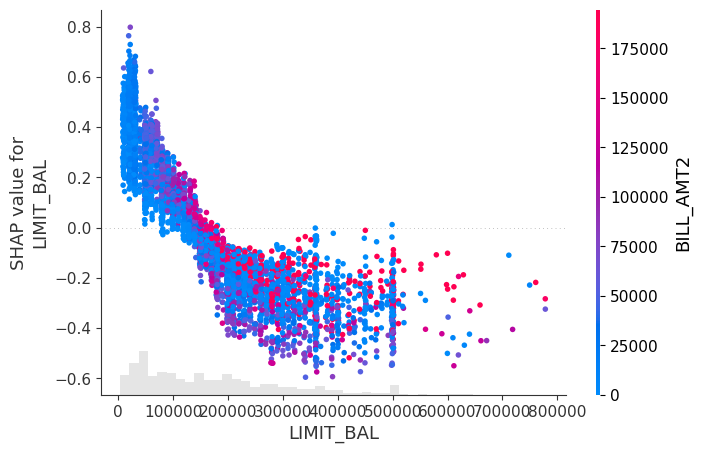

In [28]:
shap.plots.scatter(shap_values_2[:,'LIMIT_BAL'], color=shap_values_2)

According to the SHAP summary plot, BILL_AMT2 has the strongest interaction with LIMIT_BAL. For most values of LIMIT_BAL, if the amount of the bill from two months previous (BILL_AMT2) was particularly high, this leads to more positive SHAP values, indicating an increased risk of default. This is evident in the scatter plot, as most of the reddest colored dots appear along the top of the band of dots. This suggests that even if a borrower was given a large credit limit, if their bill becomes very large, it may signal an increased risk of default.